# Bayesian Modeling and Markov Chain Monte Carlo

### Data Science 350

## Overview

This notebook introduces you to a general and flexible form of Bayesian modeling using the **Makov chain Monte Carlo** methods. 

![](img/Flips.png)


***
**Note:** To run this notebook you must have the following packages installed:
- pymc3
***

## Review of Bayes Theorem

Recall Bayes theorem:

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Computing the normalization $P(B)$ is a bit of a mess. But fortunately, we don't always need the denominator. We can rewrite Bayes Theorem as:

$$𝑃(𝐴│𝐵)=𝑘∙𝑃(𝐵|𝐴)𝑃(𝐴)$$

Ignoring the normalizaton constant $k$, we get:

$$𝑃(𝐴│𝐵) \propto 𝑃(𝐵|𝐴)𝑃(𝐴)$$

### Bayesian parameter estimation

How to we interpret the relationships shown above? We do this as follows:

$$Posterior\ Distribution \propto Likelihood \bullet Prior\ Distribution \\
Or\\
𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠│𝑑𝑎𝑡𝑎) \propto 𝑃(𝑑𝑎𝑡𝑎|𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠)𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠) $$

These relationships apply to the observed data distributions, or to parameters in a model (partial slopes, intercept, error distributions, lasso constant,…). 

### Frequentist by Bayesian models

Let's summarize the differences between the Baysian and Frequentist views. 

- Bayesian methods use priors to quantify what we know about parameters.
- Frequentists do not quantify anything about the parameters, using p-values and confidence intervals to express the unknowns about parameters.

Accepting that both views are useful, we can contrast these methods with a chart.

![](img/FrequentistBayes.jpg)

## Grid Sampling and Scalability

Real-world Bayes models have large numbers of parameters, even into the millions. As a naive approach to Bayesian analysis would be to simply grid sample across the dimensions of the parameter space. However, grid sampling will not scale. To underestand the scaling problem, do the following thought experiment, where each dimension is sampled 100 times:

- For a 1-parameter model: $100$ samples.
- For a 2-parameter model: $100^2 = 10000$ samples.
- For a 3-parameter model: $100^3 = 10^5$ samples.
- For a 100-parameter model: $100^{100} = 10^{102}$ samples. 

As you can see, the compuational complexity of grid sampling has **exponential scaling** with dimensionality. Clearly, we need a better approach. 

## Introduction to Markov Chain Monte Carlo

Large-scale Bayesian models use a family of efficient sampling methods known as **Markov chain Monte Carlo sampling**. MCMC methods are compuationally efficient, but requires some effort to understand how it works and  what to do when things go wrong. 

### What is a Markov process?

As you might guess, a MCMC sampling uses a chain of **Markov sampling processes**. The chain is built from a sequence of individual Markov processes. A Markov process is any process that a makes a transition from one state other states with probability $\Pi$ with **no dependency on past states**. In summary, a Markov process has the  following properties:
- $\Pi$  only depends on the current state
- Transition from current state to one or more other states
- Can ‘transition’ to current state
- A matrix $\Pi$ of dim N X N for N possible state transitions
- A Markov procecss is a random walk since any possible transition to a new state, $j$, can occur from each state, $i$, if $p_{ij} \gt 0$.

Since a Markov chain is a **memoryless** sequence of Markov transition processes, we can write:

$$P(X_{t + 1}| X_t = x_t, \ldots, x_0 = x_t) = p(X_{t + 1}| x_t)$$

Since the Markov process is memoryless, the transition probability only depends on the current state, not any previous states. 

For a system with $N$ possible states we can write the transition matrix $\Pi$ for the probaility of transition from one state to another:

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1, N}\\
\pi_{2,1} & \pi_{2,2} & \cdots & \pi_{2,N}\\
\cdots & \cdots & \cdots & \cdots \\
\pi_{N,i} & \pi_{N,2} & \cdots & \pi_{N,N}
\end{bmatrix}\\
where\\
\pi_{i,j} = probability\ of\ transition\ from\ state\ i\ to\ state\ j\\
and\\
\pi_{i,i} = probability\ of\ staying\ in\ state\ i\\
further\\
\pi_{i,j} \ne \pi_{j,i}\ in\ general
$$

Notice that none of these probabilities depend on the previous state history.

### MCMC and the Metropolis Algorithm

The first MCMC sampling algorithm developed is the **Metropolis Hastings algorithm** (Metropolis et al. (1953), Hastings (1970)). This algorithm is often referred to as the Metropolis algorithm. The Metropolis algorithm has the following steps to estimate the density of the likelihood of the parameters:
1. Pick a starting point in your parameter space and evaluate the posterior according to your model. In other words, take an initial sample of the likelihood $p(data|parameters)$.
2. Choose a nearby point in parameter space randomly and evaluate the likelihood at this point. A probability distribution is used to make this random selection. The Normal distribution is a common choice.
  - If the $p(data | parameters)$ of the new point is greater than your current point, accept new point and move there.
  - If the $p(data | parameters)$ of the new point is less than your current point, only accept with probability according to the ratio:  
$$Acceptance\ probability\ = \frac{p(data | new\ parameters)}{p(data | previous\ parameters)}$$.
3. Repeat step 2 many times.


Now that we have outlined the basic Metropolois MCMC algorithm, let's examine some of its properties.

- Since the M-H algorithm samples the parameter space we only need to visit a limited number of points, rather than sample an entire grid. 
- The M-H algorithm is guaranteed to **eventually converge** to the underlying distribution.
- If there is high serial correlation from one sample to the next in M-H chain converges slowly. 
- To ensure efficient convergence we Need to ‘tune’ the state selection probability distribution used to find the next point. For example if we use Normal distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, there are large jumps which slow convergence

### M-H algorithm example

Let's make these concepts concrete, by trying a simple example.

As a first step, lets plot a set of points with density determined by the a bi-variate Normal distribution. Execute the code below and examine the resulting plot.

In [4]:
import pymc3

import pandas
import numpy
import seaborn
from matplotlib import pyplot

%matplotlib inline

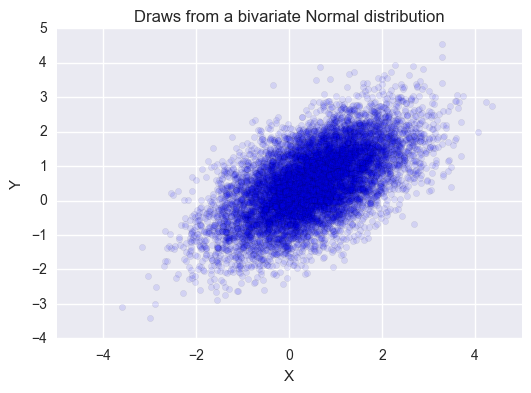

In [5]:
sigma = numpy.array([[1, .6], [.6, 1]])
mu = numpy.array([.5, .5])
random_points = numpy.random.multivariate_normal(mean=mu, cov=sigma,  size=10000)
pyplot.scatter(random_points[:, 0], random_points[:, 1], alpha=.1)
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.title('Draws from a bivariate Normal distribution')

This plot looks as expected. The density of the dots is proportional to the probabilities. You can see the effect of the covariance structure in these data.

As a next step, let's look at the density of the marginal probabilites of the $X$ and $Y$ variables. The code in the cell below plots histogram and density plots of the marginals. Execute this code and examine the result. 

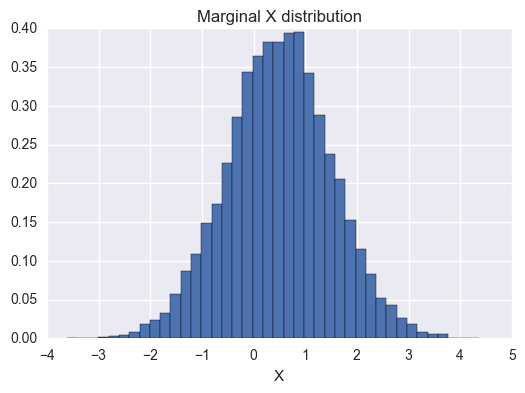

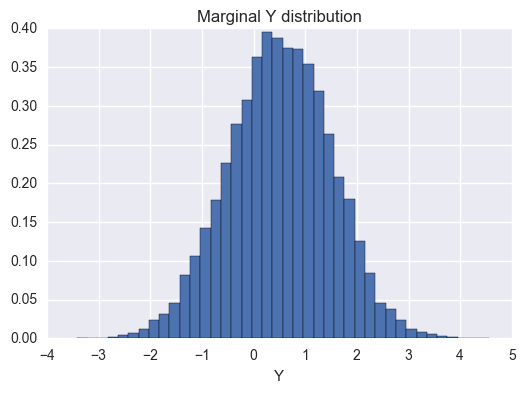

In [6]:
pyplot.hist(random_points[:, 0], normed=True, bins=40)
pyplot.title('Marginal X distribution')
pyplot.xlabel('X')
pyplot.show()

pyplot.hist(random_points[:, 1], normed=True, bins=40)
pyplot.title('Marginal Y distribution')
pyplot.xlabel('Y')

You can see that these distributions are approimately Normal, but with a right skew. 

Now, we are ready to sample these data using the M-H MCMC algorithm. The code in the cell below performs the following operations:

1. Compute the likelihood of the bi-variate Normal distribution. 
2. Initialize the chain.
3. Initialize some performance statistics.
4. Sample the likelihood of the data using the M-H algorithm.
5. Plot the result.

Execute this code and examine the result. 

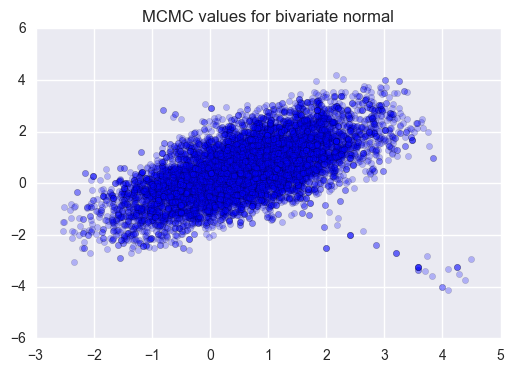

In [7]:
x = [0, 0]

# Calculate the likelihood of a vector `x` for a multivariate normal
# distribution MVN(mu, sigma)
def likelihood(x, mu, sigma):
    x = numpy.asarray(x)
    numerator = numpy.exp(-numpy.matrix(x-mu)
                  * numpy.linalg.inv(sigma)
                  * numpy.matrix(x-mu).T/2)
    denominator = (numpy.pi * numpy.sqrt(numpy.linalg.det(sigma) / 2))
    return numpy.asscalar(numerator) / denominator

# where to start
chain = [[4, -4]]
chain_length = 10000

# Evaluate the current position
current_likelihood = likelihood(chain[0], mu, sigma)

# Keep track of how often we accept or reject a proposal
accept_count = 0
reject_count = 0

for i in range(chain_length-1): # chain length minus 1 because we already have a point (the starting point)
    # Sample the direction of the move we'll propose
    delta = numpy.random.multivariate_normal([0, 0], numpy.diag([.1, .1]))
    # Our new proposal point is our previous position plus the sampled move
    proposed = chain[-1] + delta
    proposed_likelihood = likelihood(proposed, mu, sigma)
    
    # Accept according to probability
    if (numpy.random.uniform() < (proposed_likelihood / current_likelihood)):
        accept_count += 1
        current_likelihood = proposed_likelihood
        chain.append(proposed)
    else:
        chain.append(chain[-1])
        reject_count += 1
    
chain = numpy.asarray(chain)
pyplot.scatter(chain[:, 0], chain[:, 1], alpha=.25)
_ = pyplot.title('MCMC values for bivariate normal')

Notice the long 'tail' on the sampled distribution. This behavior arrises from the initial wandering of the Markov chain as it finds the high probability regions of the distribution. This period in which the Markov chain wanders is known as the **burn-in period**.

The code in the cell below, plots the same Markov chain, but with the first 1000 values removed. The remaining samples are from the post burn-in chain. 

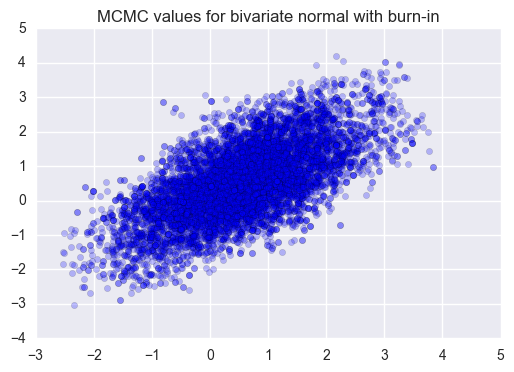

In [8]:
num_burnin = round(.1 * chain_length)

pyplot.scatter(chain[num_burnin:, 0], chain[num_burnin:, 1], alpha=.25)
_ = pyplot.title('MCMC values for bivariate normal with burn-in')

In the plot above you can see that there is no 'tail' in the sampled distribution. As expected, the tail was sampled during the burn-in period and was not significant in sampling the distribution.

Let's plot the density of the marginal distribution of these samples. We can then compaire these densities to those of the orginal data we generated. The code in the cell below plots a histogram of the sampled marginal distributions along with the density of the original samples. Execute this code and compare the results.  

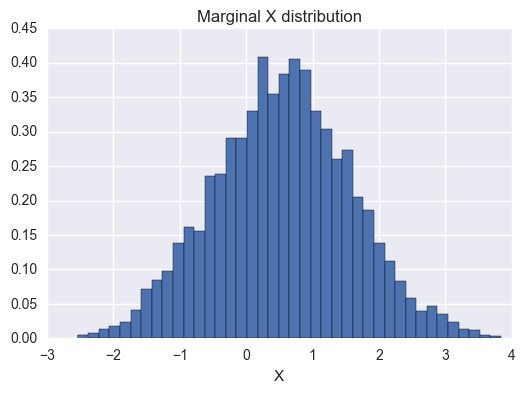

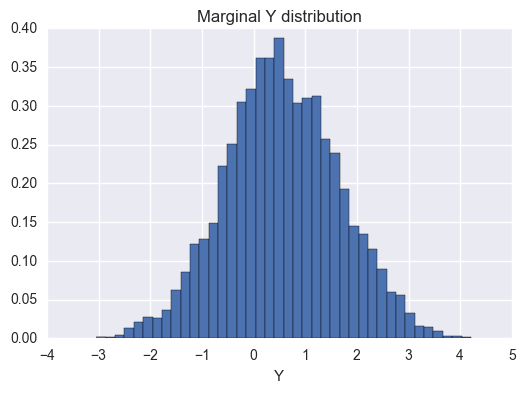

In [9]:
pyplot.hist(chain[num_burnin:, 0], normed=True, bins=40)
pyplot.title('Marginal X distribution')
pyplot.xlabel('X')
pyplot.show()

pyplot.hist(chain[num_burnin:, 1], normed=True, bins=40)
pyplot.title('Marginal Y distribution')
_ = pyplot.xlabel('Y')

Notice that the histograms of the sampled marginal distributions are close to the margianl density of the original data. There is some skew as a result of sampling error.

Next, lets compare the **Maximum a posteriori or MAP** point of the sampled marginal distributions to the original means for $x$ and $y$. The code in the cell below approximates the MAP using the `mean` function. Execute this code and compaire the results to the original data with $x = 0.5$ and $y = 0.5$. 

In [10]:
mcmc_map = numpy.mean(chain, axis=0)
mcmc_map

array([ 0.59036941,  0.54619082])

The MAP values of the sampled marginal distributions are close to the values for the original data. However, the mean approximation for the MAP seems to be biased by the skew in the sampled distribution.

Let's turn our attention to the convergence properties of the M-H MCMC sampler. The **acceptance rate** and **rejection rate** are key convergance statistics for the M-H alorithm. A low acceptance rate and high rejection rate are signs of poor convergane. Execute the code in the cell below which computes and displays these statistics and examine the results.  

In [11]:
print('Acceptance rate = %.2f' % (accept_count / chain_length))
print('Rejection rate = %.2f' % (reject_count / chain_length))

Acceptance rate = 0.81
Rejection rate = 0.19


These statistics indicate good convergance with a fairly low rejection rate.

Another way to evaluate the convergence of MCMC algorithms is to look at the **trace** of the samples. The trace is a plot of the sample value with sample number. The code in the cell below plots the trace for both the $x$ and $y$ samples, including the burn-in period. Execute this code and examine the results. 

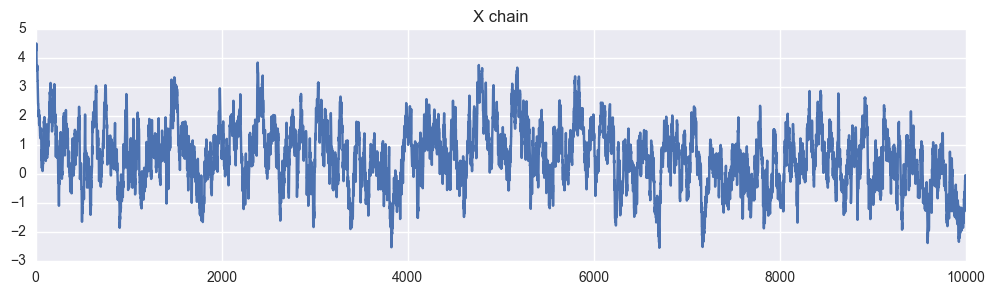

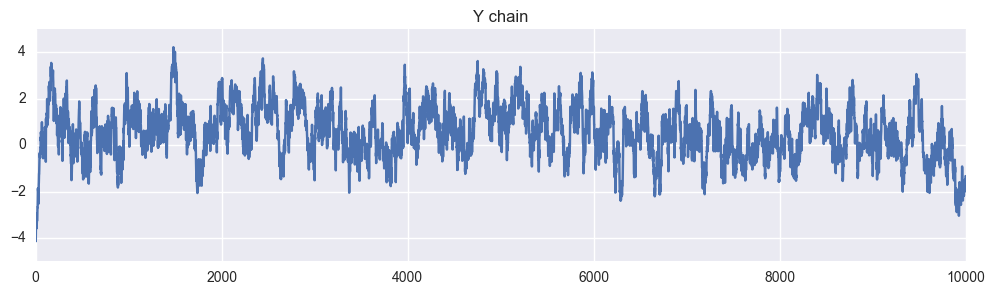

In [12]:
pyplot.figure(figsize=(12, 3))
pyplot.plot(chain[:, 0])
pyplot.title('X chain')

pyplot.figure(figsize=(12, 3))
pyplot.plot(chain[:, 1])
pyplot.title('Y chain')

Examine these sample traces. Notice that there is a significant excersion during the inital burn-in period. After the inital burn-in you can see that the sampling wanders around the mode of the distribution, as it should. 

Let's look at a close-up view the portion of these traces just after the burn-in period. The code in the cell below plots samples 1000 to 2000. Execute this coded and examine the results. 

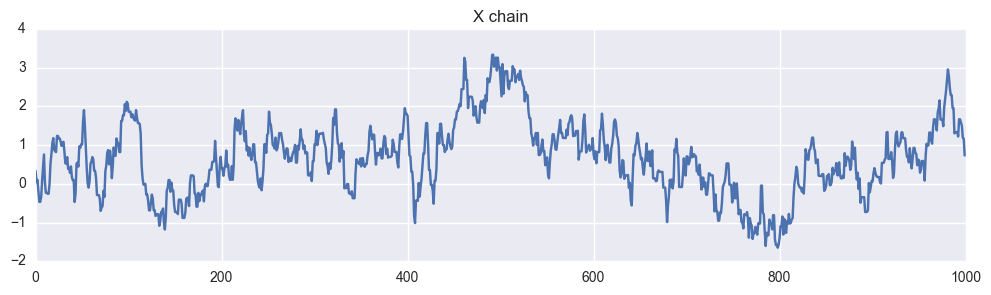

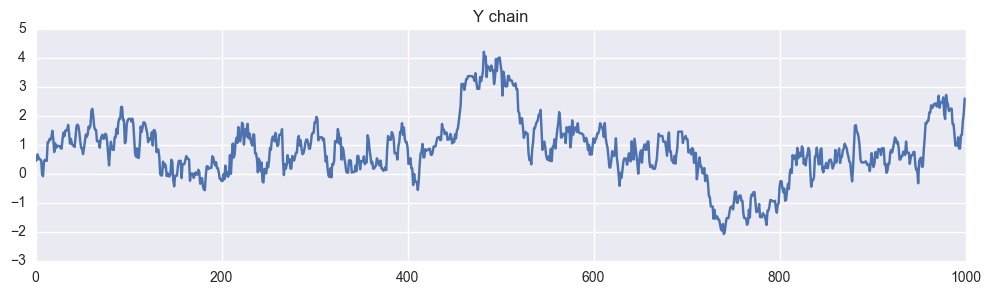

In [13]:
## Look at a shorter segment of the chain
# Always look at the chain, we would like random noise centered around means
pyplot.figure(figsize=(12, 3))
pyplot.plot(chain[1000:2000, 0])
pyplot.title('X chain')

pyplot.figure(figsize=(12, 3))
pyplot.plot(chain[1000:2000, 1])
pyplot.title('Y chain')

Notice that, for the most part, the samples are centered on the MAP for $x$ and $y$. This is the ideal behavior of the M-H algorithm. 

Finally, let's take a look at the autocorrelation of our samples

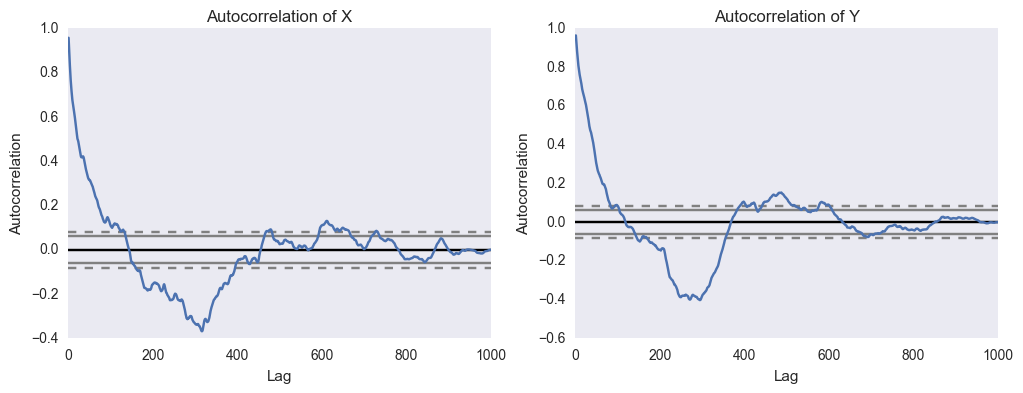

In [15]:
pyplot.figure(figsize=(12, 4))
pyplot.subplot(1, 2, 1)
pyplot.title('Autocorrelation of X')
pandas.plotting.autocorrelation_plot(chain[1000:2000, 0], ax=pyplot.gca())

pyplot.subplot(1, 2, 2)
pyplot.title('Autocorrelation of Y')
pandas.plotting.autocorrelation_plot(chain[1000:2000, 1], ax=pyplot.gca())

## Gibbs Sampling and Hierarchical Models

With some experience with the Metropolis-Hastings MCMC algotithm, let's try a Bayes hierarchical model example using Gibbs sampled MCMC. Hierarchical models can be quite complex and provide a great deal of flexibility. The Gibbs sampler can provide a significant improvement in efficiency over the Metropolis-Hastings algorthm. 

### Gibbs sampling

The Metropolis-Hastings algorithm is a useful tool. However, this algorithm can suffer from slow convergence for several reasons:

- Samples from the M-H algorithm generally have a fairly high serial correlation. This problem results from taking steps in random directions.
- As already mentioned, we need to ‘tune’ the state selection probability distribution used to find the next point. For example if we use Normal distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, there are large jumps which slow convergence.

The Gibbs sampler (Geman and Geman, 1984) is an improved MCMC sampler which speeds convergance. The basic Gibbs sampler algorithm has the following steps:

1. For an N dimensional parameter space, $\{ \theta_1, \theta_2, \ldots, \theta_N \}$, find a random starting point. 
2. Starting with dimension $1$, cycle through each dimension in order, $\{1, 2, 3, \ldots, N\}$:  
  - Sample the marginal distribution of the parameter based on the probability distribution of the parameter given the data and other parameter values:
  $$p(\theta_1|D, \theta_2, \theta_3, \ldots, \theta_N)\\ 
  where\\
  D\ is\ the\ data$$
  - Repeat this sampling proceedure for each remaining dimension in order, $\{2, 3, \ldots, N\}$.
4. Repeat step 2 until convergance.    

From this simplifed description of the Gibbs sampling algorithm you can infer:

- When compared to the Metropolis-Hastings algorithm, the Gibbs sampler reduces serial correlation owing to the reduced round-robin nature of the sampling.   
- There are no tuning parameters since sampling is based on the marginals of the likelihood.

### Hierarchical modeling example

In this case, we will under take a univariate regression problem using synthetic data. The regression model has two parameters a slope and an intercept. The variance of the data is an additionl 'nuisance' parameter. To compute these parameters, accounting for their dependency, we will use a hierarchical Bayes model. 

Hierarchical Bayes models depend on the **chain rule** for Bayes theorem. The chain rule allows us to expand Bayes theorm to accommodate multi-parameter models. We can write the basic chain rule for Bayes theorem like this:

$$p(\theta, \sigma | D) \propto p(D| \theta, \sigma) p(\theta, \sigma)\\
\propto p(D | \theta) p(\theta | \sigma) p(\sigma)\\
\propto\ Likelihood\ *\ Prior\ of\ \theta\ given\ \sigma\ *\ Prior\ of\ \sigma$$

As you can see, a complex multi-parameter Bayesian model is transformed to a hierarchy. The hierarchy is a chain of prior distributions (unconditional and conditional) and a likelihood dependent only on one parameter.  

As a first step the code in the cell below generates bi-variate data with Normally distributed errors and plots the result. Execute this code to compute the data.     

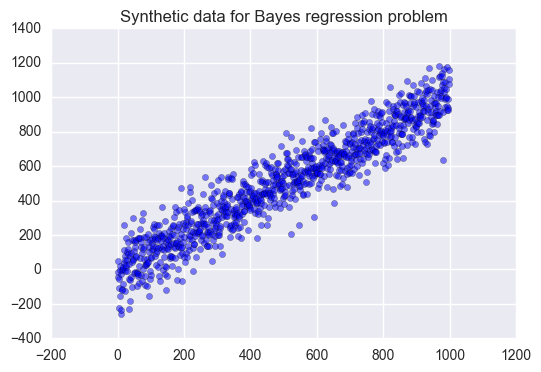

In [21]:
## Set up the data set as a regression problem
N = 1000
x = numpy.arange(N)
epsilon = numpy.random.normal(0, 100, N)
y = x + epsilon

pyplot.scatter(x, y, alpha=.5)
_ = pyplot.title('Synthetic data for Bayes regression problem')

The regression model has two parameters, a slope and an intercept, which we will call $a$ and $b$. We will use a **hierarchical Bayes model**. The model is considered hierarchical since the quantity we really want to know, the posterior distribution of the label, which we will refer to as $\hat{y}$, depends on the distribution of other model parameters. In this case, the posterior distribution of $\hat{y}$ depends on both the regression coeficients and an error term. We can visualize the hierarchical relationships in this model in the diagram below.

![](img/HierarchicalModel.jpg)
<center> **Hierarchical model for the posterior distribution of y** </center>

In mathematical terms we can define the hierarchical model as follows:
 
1. The prior of the dispursion, $\sigma$, of the Power distribution is defined as the Uniform distribution:
$$U(0, 100)$$
2. The variance (dispersion) of the label values is modeled as an Power distribution:
$$\tau = a x^\sigma = -2 x^\sigma$$
3. The prior distributions of the regression model, $a$ and $b$, are modeled as Normal distributions:
$$N(0, 0.01)$$
4. The regression model for estimating $\hat{y_i}$ is defined by:
$$\hat{y_i} = a + b x_i$$
5. The posterior distribution of the label values is modeled as a Normal distribution:
$$N(\hat{y_i}, \tau)$$

### Computing the model with pyMC3

To compute the MCMC samples we will use the `pymc3` package

Each of the variables in the Bayesian model diagram above are represented by pyMC3 objects in the model definition below. The model combines our data (`x` and `y`) with the variables we'd like to estimate: our intercept `a` and slope `b`

Internally, MCMC uses the No U-Turn Sampler (NUTS) for simulation. Instead of proposing new samples with the Metropolis-Hastings acceptance criteria or exploring using the Gibbs sampler approach as described above, NUTS models the exploration as the movement of a particle through a field. The field that guides the movement of the particle through the space is derived from the target probability distribution, such that the particle is drawn towards dense (high likelihood) regions of the space. This strategy directs the exploration of the space rather than using a random wandering behavior as we saw with MCMC methods above, and in doing so is typically more efficient.

In [30]:
def create_model(x, y):
    model = pymc3.Model()

    with model:
        a = pymc3.Normal('a', mu=0, sd=10)
        b = pymc3.Normal('b', mu=0, sd=10)
        
        # We model the y variable (y_hat) as a linear function of our input 
        # array x, having intercept=a and slope=b.
        y_hat = a + b * x

        sigma = pymc3.Uniform('sigma', lower=0, upper=100)
        tau = pow(sigma, -2)

        # Here we assign our y array as the observed values of the model.
        y_obs = pymc3.Normal('y_obs', mu=y_hat, tau=tau, observed=y)

    return model

In [31]:
model = create_model(x, y)

***
**Your turn.** Use a reduced size data set of 50 samples to compute another Bayesian regression model. Ensure you do the following:
1. Use the `numpy.random.choice` function to create an index for the samples of `x` and `y`.
2. You may wish to plot your sampled data to ensure your sampling worked as desired.
3. Define a new model with the sampled dataset.
***

### Evaluating the model

With the model compiled and the posterior sampled, we can now extract the samples. The `pymc3.sample` function extracts the samples from our Markov chain. Execute this code to extract the samples. 

In [32]:
num_chains = 4

## Compute some samples
with model:
    samples = pymc3.sample(1000, chains=num_chains)
samples

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_interval__, b, a]
The acceptance probability does not match the target. It is 0.884387163321, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.888069139408, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.880759229346, but should be close to 0.8. Try to increase the number of tuning steps.


<MultiTrace: 4 chains, 1000 iterations, 4 variables>

***
**Your turn.** Extract samples for the model you created with 50 data points. Make sure you give another name to these samples. 
***

We can now examine the convergence properties of the MCMC. As a first step, the code below plots the traces of chains (4) and the marginal density of the slope and intercept parameters, $a$ and $b$. Execute this code and examine the results. 

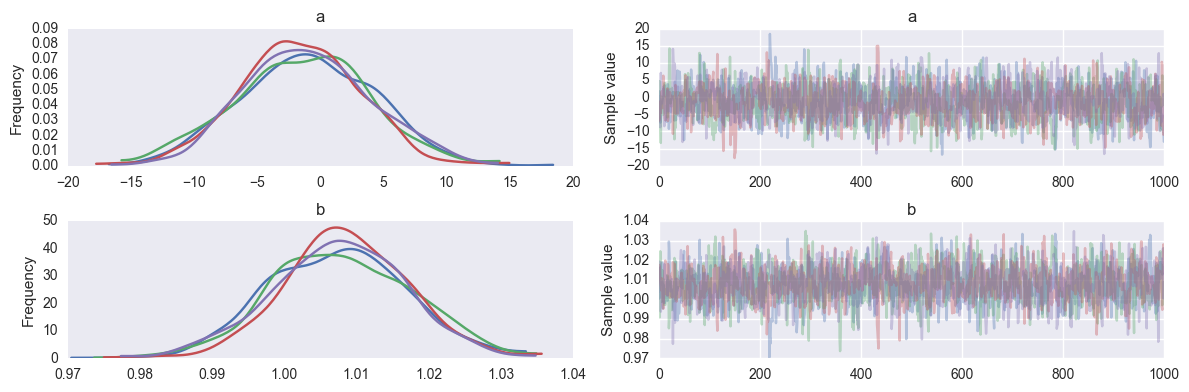

In [33]:
_ = pymc3.traceplot(samples, varnames=['a', 'b'])

Examine these plots, noting the following:

1. The trace plots on the right show the path of the 4 MCMC chains for the $a$ and $b$ model parameters.
2. The density for the $a$ and $b$ model parameters are shown on the left. The MAP value of the intercept (`a`) is close to the actual value of  0.0, and the MAP value of the slope is close to the actual value of 1.0 (`b`).

***
**Your turn.** Plot the samples you extracted from the model computed with 50 data points. How do these results compare the model computed with 1000 data points.
***

pyMC3 can also print summary statistics for the MCMC sampling.

In [34]:
pymc3.summary(samples, varnames=['a', 'b'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-1.276913,5.065925,0.129563,-11.512065,8.259004,1471.0,1.001639
b,1.007809,0.009248,0.000231,0.990042,1.026208,1416.0,1.001237


The summary shows a lot of useful information, including:
    
1. The mean of the coefficient values. You can see that the intercept is close to zero and the slope is close to 1
2. The standard deviation (`sd`) of the coefficient values. In this case you can see that the intercept, $a$, is close to 0, as well as the slope, $b$.
3. The sampling error (`mc_error`) is the error arising from the MCMC sampling.
4. The quantiles for the model parameters (`hpd_2.5` and `hpd_97.5`)
5. The effective number of samples (`n_eff`) out of `n_chain` * `n_samples` possible samples
6. The Gelman-Rudin statistic (`Rhat`) which is explained below

***
**Your turn.** Display the summary of the model you created with 50 data points. Compare the results to the model computed using 1000 data points.
***

Let's compaire the results from MCMC samples with a conventional linear model. The code in the cell below computes a linear model and prints the summary. Execute this code and compare the results to the MCMC sample results. 

In [35]:
import sklearn.linear_model


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(x.reshape((-1, 1)), y)

print('Linear model parameters: y ~ (a=%.3f) + (b=%.3f)*x' 
      % (linear_model.intercept_, linear_model.coef_[0]))

Linear model parameters: y ~ (a=-1.720) + (b=1.008)*x


The values and error estimates for the intercept and  slope parameters from the conventional linear model are close to those obtained with MCMC sampling. 

The parameters of the linear model match the true intercept and slope closely, but the
 linear model provides no information on the  posterior distribution beyond these simple metrics. For example, there are no quantiles for the coefficients. 

***
**Your turn.** Compute and print the summary of a linear model for the 50 data points you used for your Bayesian model. Compare the results to the Bayesian model and the linear model computed using 1000 data points.
***

Another way to examine the convergence of a Markov is to plot the cumulative values of the coefficients and their standard deviation vs. the sample number. The `cumuplot` function creates just such a plot for a coda Markov chain. Execute the code in the cell below and examine the results for each chain. 

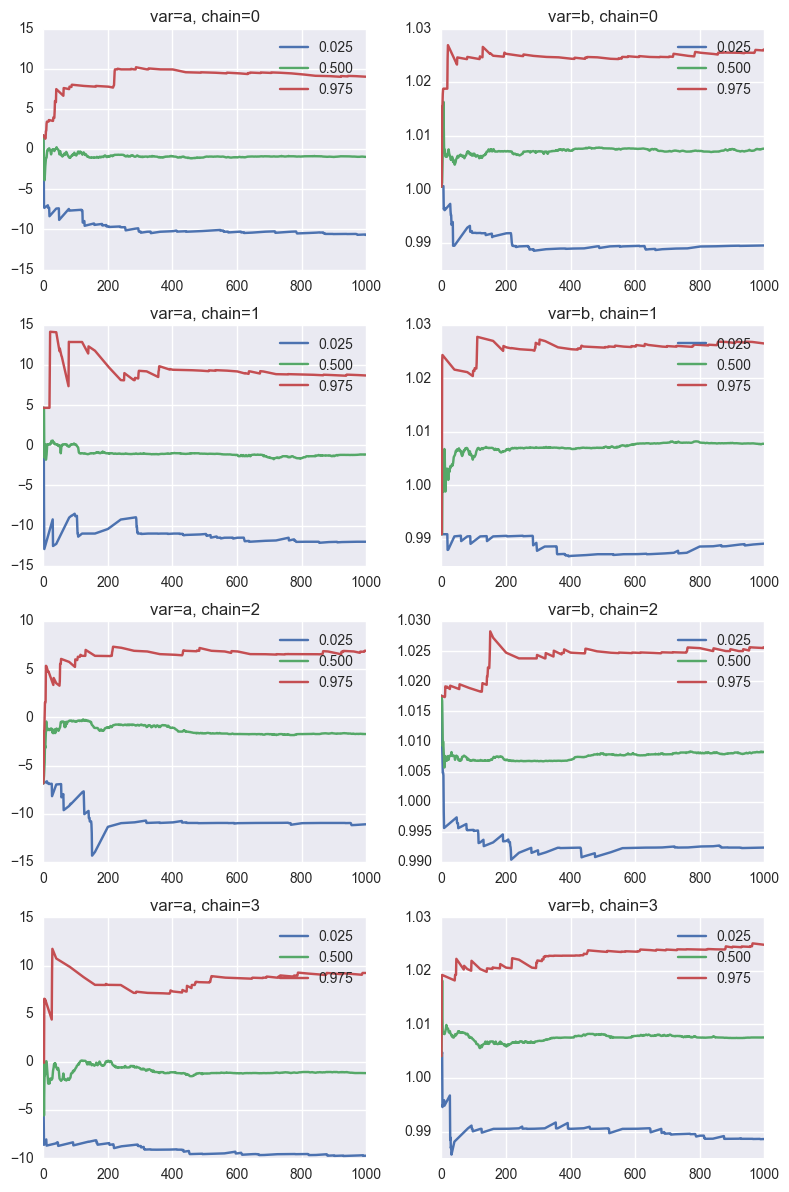

In [36]:
import pandas


def trace_variable(samples, varnames, quantiles=(0.025, 0.5, 0.975)):
    for i, chain in enumerate(samples.chains):
        for j, varname in enumerate(varnames):
            pyplot.subplot(len(samples.chains), len(varnames), i * len(varnames) + j + 1)
            values = pandas.Series(samples.get_values(varname, chains=chain))
            for q in quantiles:
                pyplot.plot(
                    values.expanding(min_periods=1).quantile(q), 
                    label='%.3f' % q)
            pyplot.title('var=%s, chain=%d' % (varname, chain))
            pyplot.legend(loc='upper right')
    pyplot.tight_layout()


pyplot.figure(figsize=(8, 12))
trace_variable(samples, ['a', 'b'])

The plots show that each chain converges to similar values and with similar standard deviations. This indicates that the Markov chains are converging properly.

The **Gelman-Rudin statistic** (Gelman and Rudin, 1992) measures the ratio of the **variance shrinkage between chains** to the **variance shrinkage within chains**. The Gelman-Rudin statistic should coverge to 1.0. The code in the cell below uses the `pymc3.forestplot` function to produce a plot of the Gelman-Rudin statistic and its 95% credible interval. Execute this code and examine the result (R-hat is the Gelman-Rudin statistic). 

In [37]:
pymc3.forestplot(samples, varnames=['a', 'b'])

ValueError: to_rgba: Invalid rgba arg "C0"
to_rgb: Invalid rgb arg "C0"
could not convert string to float: 'c0'

We can also get the value of the Gelman-Rudin statistic for our variables like so:

In [38]:
pymc3.diagnostics.gelman_rubin(samples, varnames=['a', 'b'])

{'a': 1.0016391686091557, 'b': 1.0012366300027062}

The Gelman-Rudin statistic values for both model parameters converged to near 1.0.

As we already discussed, the convergance of MCMC algorithms is slowed by **autocorrelation** between the samples. `pyMC3` provides the `autocorrplot()` function for examining the autocorrelation in Markov chains. The function creates autocorrelation function plots for each parameter and chain combination. 

To examine the results for the Markov chains, execute the code in the cell below. 

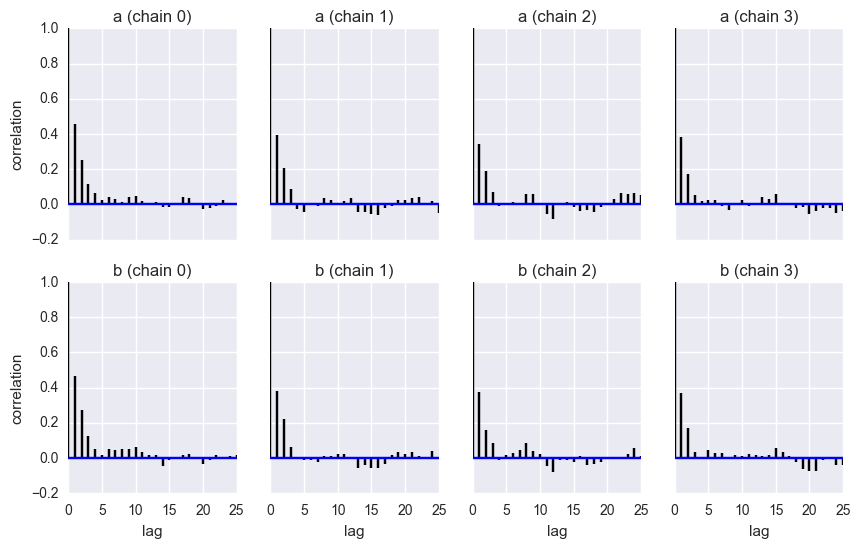

In [39]:
_ = pymc3.autocorrplot(samples, varnames=['a', 'b'], max_lag=25, figsize=(10, 6))

You can see that there are a several significant lag values of the ACF. This means that the convergence of the Markov chains was impeded by this autocorrelation.

Given the significant autocorrelation in the samples, we can compute an **effective sample size or ESS**. If there is significant autocorrelation the ESS will be significantly less than the raw sample size. We can compute the ESS as follows:

$$ESS = \frac{N}{1 + 2 \sum_k ACF(k)}$$

The code in the cell below computes the ESS and rejection rate for the Markov chain. Execute this code and examine the results. 

In [40]:
## What is the effective size of the sample?
pymc3.diagnostics.effective_n(samples, varnames=['a', 'b'])

{'a': 1471.0, 'b': 1416.0}

Note that the effective number of samples is also provided as part of the standard trace summary (see column `n_eff`):

In [41]:
pymc3.summary(samples)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-1.276913,5.065925,0.129563,-11.512065,8.259004,1471.0,1.001639
b,1.007809,0.009248,0.000231,0.990042,1.026208,1416.0,1.001237
sigma,98.055265,1.335571,0.028117,95.531139,99.999402,1915.0,1.000793


You can see that the effective sample size is much lower than the raw sample size. Still, the effective sample sizes appears to be sufficient to provide good estimates of the posterior distributions of the parameters. 

## Summary

In this notebook you have done the following:

- Reviewed the basic properties of a Markov process.
- Perform a simple Markov chain Monte Carlo using the Metropolious-Hastings algorithm.
- Created and computed a hierarchical Bayes model using No U-Turn Sampling.
- Evaluated the convergance of the model. 

#### Copyright 2017, Stephen F Elston. All rights reserved. 